### **Train a Bayesian model from scratch for MNIST using AlexNet architecture**

The following notebook can be run on google Colab.

In [1]:
!pip3 install pyro-ppl==0.2.1

You should consider upgrading via the 'c:\users\tomva\onedrive\ku leuven\master theory and research\internship\rtnet\venv\scripts\python.exe -m pip install --upgrade pip' command.


In [2]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import pyro
from pyro.distributions import Normal, Categorical
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

%matplotlib inline

In [3]:
# Check Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
#rtnet_path = os.path.join("drive", "MyDrive", "RTNet")


**Load the data**

In [53]:
AlexTransform = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2411, 0.2377, 0.2563])
])


data_path = os.path.join("..", "..", "data", "cifar-data")

train_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10(data_path, train=True, download=True, transform=AlexTransform),
        batch_size=500, shuffle=True)

test_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10(data_path, train=False, download=True, transform=AlexTransform),
        batch_size=1, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [68]:
train_loader.dataset.data.shape

(50000, 32, 32, 3)

In [ ]:
import torch
from torchvision import datasets, transforms


# Initialize variables to accumulate channel sums and count total pixels
channel_sum = torch.zeros(3)
channel_squared_sum = torch.zeros(3)
num_batches = 0

for images, _ in train_loader:
    # Sum across batch and spatial dimensions (H, W), leaving channel dimension
    channel_sum += images.sum(dim=[0, 2, 3])
    channel_squared_sum += (images ** 2).sum(dim=[0, 2, 3])
    num_batches += images.shape[0] * images.shape[2] * images.shape[3]  # batch * H * W

# Calculate mean and std for each channel
channel_mean = channel_sum / num_batches
channel_std = torch.sqrt(channel_squared_sum / num_batches - channel_mean ** 2) 

print("Mean:", channel_mean)
print("Std:", channel_std)


Mean: tensor([0.4914, 0.4822, 0.4465])
Std: tensor([0.2411, 0.2377, 0.2563])


In [69]:
image, _ = next(iter(train_loader))
image.shape

torch.Size([500, 3, 227, 227])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(50000, 32, 32, 3)


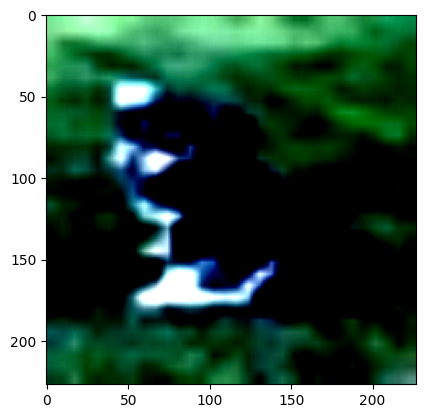

In [72]:
print(train_loader.dataset.data.shape)

plt.imshow(train_loader.dataset[70][0].permute(1,2,0))

**Define the model**

AlexNet structure

In [ ]:
# AlexNet
class alexnet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(96, 256, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(3, 2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(256, 384, 3, 1, 1),
            nn.ReLU()
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(384, 384, 3, 1, 1),
            nn.ReLU()
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(384, 256, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(3, 2)
        )

        self.fc1 = nn.Linear(256 * 6 * 6, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 10)

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = out.view(out.size(0), -1)

        out = F.relu(self.fc1(out))  # 256*6*6 -> 4096
        out = F.dropout(out, 0.5)
        out = F.relu(self.fc2(out))
        out = F.dropout(out, 0.5)
        out = self.fc3(out)
        # out = F.log_softmax(out, dim=1)

        return out

In [ ]:
# Define Hyper parameters
img_size = 28 * 28
hidden_layer_size = 1024
num_classes = 10
net = alexnet().to(device)
# softmax
log_softmax = nn.LogSoftmax(dim=1)

Model function for pyro

In [ ]:
def model(x_data, y_data):

    convLayer1_w = Normal(loc=torch.ones_like(net.conv1[0].weight), scale=torch.ones_like(net.conv1[0].weight))
    convLayer1_b = Normal(loc=torch.ones_like(net.conv1[0].bias), scale=torch.ones_like(net.conv1[0].bias))

    convLayer2_w = Normal(loc=torch.ones_like(net.conv2[0].weight), scale=torch.ones_like(net.conv2[0].weight))
    convLayer2_b = Normal(loc=torch.ones_like(net.conv2[0].bias), scale=torch.ones_like(net.conv2[0].bias))

    convLayer3_w = Normal(loc=torch.ones_like(net.conv3[0].weight), scale=torch.ones_like(net.conv3[0].weight))
    convLayer3_b = Normal(loc=torch.ones_like(net.conv3[0].bias), scale=torch.ones_like(net.conv3[0].bias))

    convLayer4_w = Normal(loc=torch.ones_like(net.conv4[0].weight), scale=torch.ones_like(net.conv4[0].weight))
    convLayer4_b = Normal(loc=torch.ones_like(net.conv4[0].bias), scale=torch.ones_like(net.conv4[0].bias))

    convLayer5_w = Normal(loc=torch.ones_like(net.conv5[0].weight), scale=torch.ones_like(net.conv5[0].weight))
    convLayer5_b = Normal(loc=torch.ones_like(net.conv5[0].bias), scale=torch.ones_like(net.conv5[0].bias))

    fc1Layer_w = Normal(loc=torch.ones_like(net.fc1.weight), scale=torch.ones_like(net.fc1.weight))
    fc1Layer_b = Normal(loc=torch.ones_like(net.fc1.bias), scale=torch.ones_like(net.fc1.bias))

    fc2Layer_w = Normal(loc=torch.ones_like(net.fc2.weight), scale=torch.ones_like(net.fc2.weight))
    fc2Layer_b = Normal(loc=torch.ones_like(net.fc2.bias), scale=torch.ones_like(net.fc2.bias))

    fc3Layer_w = Normal(loc=torch.ones_like(net.fc3.weight), scale=torch.ones_like(net.fc3.weight))
    fc3Layer_b = Normal(loc=torch.ones_like(net.fc3.bias), scale=torch.ones_like(net.fc3.bias))

    priors = {'conv1[0].weight': convLayer1_w,
              'conv1[0].bias': convLayer1_b,
              'conv2[0].weight': convLayer2_w,
              'conv2[0].bias': convLayer2_b,
              'conv3[0].weight': convLayer3_w,
              'conv3[0].bias': convLayer3_b,
              'conv4[0].weight': convLayer4_w,
              'conv4[0].bias': convLayer4_b,
              'conv5[0].weight': convLayer5_w,
              'conv5[0].bias': convLayer5_b,
              'fc1.weight': fc1Layer_w,
              'fc1.bias': fc1Layer_b,
              'fc2.weight': fc2Layer_w,
              'fc2.bias': fc2Layer_b,
              'fc3.weight': fc3Layer_w,
              'fc3.bias': fc3Layer_b}

    # lift module parameters to random variables sampled from the priors
    lifted_module = pyro.random_module("module", net, priors)
    # sample a regressor (which also samples w and b)
    lifted_reg_model = lifted_module()

    lhat = log_softmax(lifted_reg_model(x_data))

    pyro.sample("obs", Categorical(logits=lhat), obs=y_data)

Guide function for pyro

In [ ]:
softplus = torch.nn.Softplus()

def guide(x_data, y_data):

    # First layer weight distribution priors
    convLayer1w_mu    = torch.randn_like(net.conv1[0].weight)
    convLayer1w_sigma = torch.randn_like(net.conv1[0].weight)
    convLayer1w_mu_param    = pyro.param("convLayer1w_mu", convLayer1w_mu)
    convLayer1w_sigma_param = softplus(pyro.param("convLayer1w_sigma", convLayer1w_sigma))
    convLayer1_w = Normal(loc=convLayer1w_mu_param, scale=convLayer1w_sigma_param)

    # First layer bias distribution priors
    convLayer1b_mu    = torch.randn_like(net.conv1[0].bias)
    convLayer1b_sigma = torch.randn_like(net.conv1[0].bias)
    convLayer1b_mu_param    = pyro.param("convLayer1b_mu", convLayer1b_mu)
    convLayer1b_sigma_param = softplus(pyro.param("convLayer1b_sigma", convLayer1b_sigma))
    convLayer1_b = Normal(loc=convLayer1b_mu_param, scale=convLayer1b_sigma_param)

    # Second layer weight distribution priors
    convLayer2w_mu    = torch.randn_like(net.conv2[0].weight)
    convLayer2w_sigma = torch.randn_like(net.conv2[0].weight)
    convLayer2w_mu_param    = pyro.param("convLayer2w_mu", convLayer2w_mu)
    convLayer2w_sigma_param = softplus(pyro.param("convLayer2w_sigma", convLayer2w_sigma))
    convLayer2_w = Normal(loc=convLayer2w_mu_param, scale=convLayer2w_sigma_param)

    # Second layer bias distribution priors
    convLayer2b_mu    = torch.randn_like(net.conv2[0].bias)
    convLayer2b_sigma = torch.randn_like(net.conv2[0].bias)
    convLayer2b_mu_param    = pyro.param("convLayer2b_mu", convLayer2b_mu)
    convLayer2b_sigma_param = softplus(pyro.param("convLayer2b_sigma", convLayer2b_sigma))
    convLayer2_b = Normal(loc=convLayer2b_mu_param, scale=convLayer2b_sigma_param)

    # Third layer weight distribution priors
    convLayer3w_mu    = torch.randn_like(net.conv3[0].weight)
    convLayer3w_sigma = torch.randn_like(net.conv3[0].weight)
    convLayer3w_mu_param    = pyro.param("convLayer3w_mu", convLayer3w_mu)
    convLayer3w_sigma_param = softplus(pyro.param("convLayer3w_sigma", convLayer3w_sigma))
    convLayer3_w = Normal(loc=convLayer3w_mu_param, scale=convLayer3w_sigma_param)

    # Third layer bias distribution priors
    convLayer3b_mu    = torch.randn_like(net.conv3[0].bias)
    convLayer3b_sigma = torch.randn_like(net.conv3[0].bias)
    convLayer3b_mu_param    = pyro.param("convLayer3b_mu", convLayer3b_mu)
    convLayer3b_sigma_param = softplus(pyro.param("convLayer3b_sigma", convLayer3b_sigma))
    convLayer3_b = Normal(loc=convLayer3b_mu_param, scale=convLayer3b_sigma_param)

    # Fourth layer weight distribution priors
    convLayer4w_mu    = torch.randn_like(net.conv4[0].weight)
    convLayer4w_sigma = torch.randn_like(net.conv4[0].weight)
    convLayer4w_mu_param    = pyro.param("convLayer4w_mu", convLayer4w_mu)
    convLayer4w_sigma_param = softplus(pyro.param("convLayer4w_sigma", convLayer4w_sigma))
    convLayer4_w = Normal(loc=convLayer4w_mu_param, scale=convLayer4w_sigma_param)

    # Fourth layer bias distribution priors
    convLayer4b_mu    = torch.randn_like(net.conv4[0].bias)
    convLayer4b_sigma = torch.randn_like(net.conv4[0].bias)
    convLayer4b_mu_param    = pyro.param("convLayer4b_mu", convLayer4b_mu)
    convLayer4b_sigma_param = softplus(pyro.param("convLayer4b_sigma", convLayer4b_sigma))
    convLayer4_b = Normal(loc=convLayer4b_mu_param, scale=convLayer4b_sigma_param)

    # Fifth layer weight distribution priors
    convLayer5w_mu    = torch.randn_like(net.conv5[0].weight)
    convLayer5w_sigma = torch.randn_like(net.conv5[0].weight)
    convLayer5w_mu_param    = pyro.param("convLayer5w_mu", convLayer5w_mu)
    convLayer5w_sigma_param = softplus(pyro.param("convLayer5w_sigma", convLayer5w_sigma))
    convLayer5_w = Normal(loc=convLayer5w_mu_param, scale=convLayer5w_sigma_param)

    # Fifth layer bias distribution priors
    convLayer5b_mu    = torch.randn_like(net.conv5[0].bias)
    convLayer5b_sigma = torch.randn_like(net.conv5[0].bias)
    convLayer5b_mu_param    = pyro.param("convLayer5b_mu", convLayer5b_mu)
    convLayer5b_sigma_param = softplus(pyro.param("convLayer5b_sigma", convLayer5b_sigma))
    convLayer5_b = Normal(loc=convLayer5b_mu_param, scale=convLayer5b_sigma_param)

    # First fully connected layer weight distribution priors
    fc1w_mu = torch.randn_like(net.fc1.weight)
    fc1w_sigma = torch.randn_like(net.fc1.weight)
    fc1w_mu_param = pyro.param("fc1w_mu", fc1w_mu)
    fc1w_sigma_param = softplus(pyro.param("fc1w_sigma", fc1w_sigma))
    fc1Layer_w = Normal(loc=fc1w_mu_param, scale=fc1w_sigma_param).independent(1)

    # First fully connected layer bias distribution priors
    fc1b_mu = torch.randn_like(net.fc1.bias)
    fc1b_sigma = torch.randn_like(net.fc1.bias)
    fc1b_mu_param = pyro.param("fc1b_mu", fc1b_mu)
    fc1b_sigma_param = softplus(pyro.param("fc1b_sigma", fc1b_sigma))
    fc1Layer_b = Normal(loc=fc1b_mu_param, scale=fc1b_sigma_param)

    # Second fully connected layer weight distribution priors
    fc2w_mu = torch.randn_like(net.fc2.weight)
    fc2w_sigma = torch.randn_like(net.fc2.weight)
    fc2w_mu_param = pyro.param("fc2w_mu", fc2w_mu)
    fc2w_sigma_param = softplus(pyro.param("fc2w_sigma", fc2w_sigma))
    fc2Layer_w = Normal(loc=fc2w_mu_param, scale=fc2w_sigma_param).independent(1)

    # Second fully connected layer bias distribution priors
    fc2b_mu = torch.randn_like(net.fc2.bias)
    fc2b_sigma = torch.randn_like(net.fc2.bias)
    fc2b_mu_param = pyro.param("fc2b_mu", fc2b_mu)
    fc2b_sigma_param = softplus(pyro.param("fc2b_sigma", fc2b_sigma))
    fc2Layer_b = Normal(loc=fc2b_mu_param, scale=fc2b_sigma_param)

    # Third fully connected layer weight distribution priors
    fc3w_mu = torch.randn_like(net.fc3.weight)
    fc3w_sigma = torch.randn_like(net.fc3.weight)
    fc3w_mu_param = pyro.param("fc3w_mu", fc3w_mu)
    fc3w_sigma_param = softplus(pyro.param("fc3w_sigma", fc3w_sigma))
    fc3Layer_w = Normal(loc=fc3w_mu_param, scale=fc3w_sigma_param).independent(1)

    # Third fully connected layer bias distribution priors
    fc3b_mu = torch.randn_like(net.fc3.bias)
    fc3b_sigma = torch.randn_like(net.fc3.bias)
    fc3b_mu_param = pyro.param("fc3b_mu", fc3b_mu)
    fc3b_sigma_param = softplus(pyro.param("fc3b_sigma", fc3b_sigma))
    fc3Layer_b = Normal(loc=fc3b_mu_param, scale=fc3b_sigma_param)

    priors = {'conv1[0].weight': convLayer1_w,
              'conv1[0].bias': convLayer1_b,
              'conv2[0].weight': convLayer2_w,
              'conv2[0].bias': convLayer2_b,
              'conv3[0].weight': convLayer3_w,
              'conv3[0].bias': convLayer3_b,
              'conv4[0].weight': convLayer4_w,
              'conv4[0].bias': convLayer4_b,
              'conv5[0].weight': convLayer5_w,
              'conv5[0].bias': convLayer5_b,
              'fc1.weight': fc1Layer_w,
              'fc1.bias': fc1Layer_b,
              'fc2.weight': fc2Layer_w,
              'fc2.bias': fc2Layer_b,
              'fc3.weight': fc3Layer_w,
              'fc3.bias': fc3Layer_b}

    lifted_module = pyro.random_module("module", net, priors)

    return lifted_module()

**Training a model**

In [ ]:
optim = Adam({'lr': 0.01})
svi = SVI(model, guide, optim, loss=Trace_ELBO())

In [ ]:
num_iterations = 15
loss = 0

for j in range(num_iterations):
    loss = 0
    for batch_id, data in enumerate(train_loader):
        # calculate the loss and take a gradient step
        loss += svi.step(data[0].to(device), data[1].to(device))
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = loss / normalizer_train

    print("Epoch ", j, " Loss ", total_epoch_loss_train)

**Evaluation**

In [ ]:
net.eval()
num_samples = 3
def predict(x):
    sampled_models = [guide(None, None) for _ in range(num_samples)]
    yhats = [model(x).data for model in sampled_models]
    mean = torch.mean(torch.stack(yhats), 0)
    return torch.argmax(mean, dim=1)


print('Prediction when network is forced to predict')
correct = 0
total = 0

all_labels = []
all_predicted = []
for j, data in enumerate(test_loader):
    images, labels = data
    predicted = predict(images.to(device))
    total += labels.size(0)
    correct += (predicted == labels.to(device)).sum().item()
    all_labels.append(labels)
    all_predicted.append(predicted)
print("accuracy: %d %%" % (100 * correct / total))

**Save the model**

In [ ]:
path = 'INSERT PATH HERE'
model_num = '01'
torch.save({"model" : net.state_dict(), "guide" : guide}, path + "model_" + model_num + ".pt")
pyro.get_param_store().save(path + "model_" + model_num + "_params.pt")